In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\bar}{\,|\,}
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\weights}{\mathbf{w}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Text Classification 

In many applications we need to automatically classify some input text with respect to a set of classes or labels. For example,

* for information retrieval it is useful to classify documents into a set of topics, such as "sport" or "business",
* for sentiment analysis we classify tweets into being "positive" or "negative" and 
* for spam filters we need to distinguish between Ham and Spam.

<!-- TODO: Load Web Corpus, 4 Universities, something were Maxent works -->

## Text Classification as Structured Prediction
We can formalize text classification as the simplest instance of [structured prediction](/template/statnlpbook/02_methods/00_structuredprediction) where the input space $\Xs$ are sequences of words, and the output space $\Ys$ is a set of labels such as $\Ys=\{ \text{sports},\text{business}\}$ in document classification or $\Ys=\{ \text{positive},\text{negative}, \text{neutral}\} $ in sentiment prediction. On a high level, our goal is to define a model $s_{\params}(\x,y)$ that assigns high *scores* to the label $y$ that fits the text $\x$, and lower scores otherwise. The model will be parametrized by $\params$, and these parameters we will learn from some training set $\train$ of $(\x,y)$ pairs. When we need to classify a text $\x$ we have to solve the trivial (if the number of classes is low) maximization problem $\argmax_{y \in \Ys} s_{\params}(\x,y)$. 

<!-- TODO: Show a silly classifier example? --> 

In the following we will present two typical approaches to text classifiers. The first one is the standard generative model for this problem: Naive Bayes. The second one is a discriminative linear classifier. This chapter hence constitutes a shift from generative to discriminative learning. We will focus particularly on the fact that both models can use the same model structure and parameterisation, and differ only in how model parameters are trained.

## Sentiment Analysis as Text Classification
Before we go on to classification methods let us focus on a specific task: sentiment analysis. We will load data for this task from the [Movie Review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/). We will load the data into a very simple format of $(\x,y)$ Python pairs, where $\x$ corresponds to the input text document, and $y\in\{\text{pos},\text{neg}\}$ to the sentiment label. We notice that the text has already been [tokenised](tokenization.ipynb), and the whitespace is sufficient to determine token boundaries. 

In [2]:
from os import listdir
from os.path import isfile, join
def load_from_dir(directory,label):
    """
    Load documents from a directory, and give them all the same label `label`.
    Params:
        directory: the directory to load the documents from.
        label: the label to assign to each document.
    Returns:
        a list of (x,y) pairs where x is a tokenised document (list of words), and y is the label `label`.
    """
    result = []
    for file in listdir(directory):
        with open(directory + file, 'r') as f:
            text = f.read()
            tokens = [t.strip() for t in text.split()]
            result.append((tokens,label))
    return result
    
data = load_from_dir('../data/rt-2k/txt_sentoken/pos/', 'pos') + \
       load_from_dir('../data/rt-2k/txt_sentoken/neg/', 'neg')
data[3][0][:20], data[3][1]

(['a',
  'movie',
  "that's",
  'been',
  'as',
  'highly',
  'built',
  'up',
  'as',
  'the',
  'truman',
  'show',
  ',',
  'with',
  'reviews',
  'boasting',
  ',',
  '"',
  'the',
  'film'],
 'pos')

Next we devide the data into a training, development and test set. The training dataset will be used for estimating parameters of our models. The development set will allow us to test different configurations and optimise hyperparameters (or model choices) without overfitting on the test set. This problem of fitting-the-test-set is quite widespread in ML and NLP research. It has led to impressive F1 scores on certain datasets, but poor generalisation of the findings to other slightly different dataset. We will shuffle the data and then allocate 200 instances to both dev and test set, the remainder to the training set. 

In [3]:
import random 
random.seed(0)
shuffled = list(data)
random.shuffle(shuffled)
train, dev, test = shuffled[:1600], shuffled[1600:1800], shuffled[1800:]
len([(x,y) for (x,y) in train if y == 'pos']) # check balance

815

## Naive Bayes
One of the most widely used approaches to text classification relies on the so-called Naive Bayes (NB) model. In NB we use a distribution $p^{\mbox{NB}}_{\params}$ for $s_\params$. In particular, we use the *a posteriori* probability of a label $y$ given the input text $\x$ as a score for that label given the text.   

\begin{equation}
  s_{\params}(\x,\y)\ = p^{\text{NB}}_{\params}(y|\x)
\end{equation}

By Bayes Law we get

\begin{equation}
    p^{\text{NB}}_{\params}(y|\x) =
  \frac{p^{\text{NB}}_{\params}(\x|y) p^\text{NB}_{\params}(y)}{p^{\text{NB}}_{\params}(x)}  
\end{equation}

and when an input $\x$ is fixed we can focus on 

\begin{equation}\label{eq:NB}
\prob^{\text{NB}}_{\params}(\x,y)= p^{\text{NB}}_{\params}(\x|y) p^\text{NB}_{\params}(y)
\end{equation}

because in this case  $p^{\text{NB}}_{\params}(x)$ is a constant factor. In the above $p^{\text{NB}}_{\params}(\x|y)$ is the *likelihood*, and $p^\text{NB}_{\params}(y) $ is the *prior*.

<!--Let us assume that we have a number $K(\x)$ of feature functions $f_k(\x)$ that represent the input $\x$. For example, in document classification this set could be used to represent the text $\x = (x_1,\ldots,x_n)$ as a bag of words by setting $f_k(\x) = x_k$ and $K(\x) = n$. We could also use bigrams instead, setting $f_k(\x) = (x_k,x_{k+1})$ and $K(\x) = n-1$, or any other representation that is effective for distinguishing between classes of text.-->

The "naivity" of NB stems from a certain conditional independence assumption we make for the likelihood $p^{\mbox{NB}}_{\params}(\x|y)$. Note that conditional independence of two events $a$ and $b$ given a third event $c$ requires that $p(a,b|c) = p(a|c) p(b|c)$. In particular, for the likelihood in NB we have:

\begin{equation}
  p^{\text{NB}}_{\params}(\x|y) = 
  \prod_i^{\text{length}(\x)} p^{\text{NB}}_{\params}(x_i|y)
\end{equation}

That is, NB makes the assumption that the observed words are independent of each other when *conditioned on the label* $y$. 

### Parametrisation
The NB model has the parameters $\params=(\balpha,\bbeta)$ where 

\begin{split}
  p^{\text{NB}}_{\params}(f|y) & = \alpha_{f,y} \\\\
  p^{\text{NB}}_{\params}(y) & = \beta_{y}.
\end{split}

That is, $\balpha$ captures the per-class feature weights, and $\bbeta$ the class priors. 

### Training the Naive Bayes Model

The NB model again can be trained using Maximum Likelihood estimation. This amounts to setting 

\begin{split}
  \alpha_{x,y} & = \frac{\counts{\train}{x,y}}{\sum_{x'}\counts{\train}{x',y}}\\\\
  \beta_{y} & = \frac{\counts{\train}{y}}{\left| \train \right|}
\end{split}

### Laplace Smoothing
Just as it was the case for [language models](language_models.ipynb), the MLE can produce zero probabilities for unseen words in the test set. We can distinguish between two types of events at test: 

1. We encounter a word that appears in the training set, but never for a given class.
2. We encounter a word that does not appear in the training set at all.

We address the first problem by using Laplace Smoothing and pseudo-counts. Let $V$ be the full training set vocabulary, and $\gamma$ a pseudo-count, then

\begin{split}
  \alpha^\gamma_{x,y} & = \frac{\counts{\train}{x,y} + \gamma}{|V|\gamma + \sum_{x'}\counts{\train}{x',y}}.\\\\
\end{split}

Let us implement the MLE training algorithm with Laplace Smoothing for an NB model in Python:

In [4]:
from collections import defaultdict

def train_nb(data, pseudo_count=0.0):
    """
    Trains a NB model using MLE.
    Params:
        data: a list of (x,y) pairs where x is a list of words, and y is a label.
    Returns:
        The pair (alpha,beta) where alpha are the per class word emission probabilities as a dictionary 
        from pairs of word and label to probability, and beta the class priors as a dictionary from 
        class name to probability.
    """
    alpha = defaultdict(float)
    beta = defaultdict(float)
    vocab = set(w for x,_ in data for w in x)
    labels = set(y for _,y in data)
    norm = 0
    for x,y in data:
        for w in x:
            beta[y] += 1.0
            alpha[w,y] += 1
            norm += 1
    for y in labels:
        for w in vocab:
            alpha[w,y] = (alpha[w,y]+pseudo_count) / (beta[y] + len(vocab) * pseudo_count)

    for y in list(beta.keys()):
        beta[y] = beta[y] / norm
    return (alpha, beta)
    
theta = (alpha, beta) = train_nb(train)

It is useful to inspect the learned parameters of the NB model, in particular because they are easy to interpret. The class prior looks sensible:

In [5]:
beta

defaultdict(float, {'neg': 0.46393907123093997, 'pos': 0.53606092876906})

Let us look at the $\balpha$ parameters that correspond to the probability of generating a word given a class.

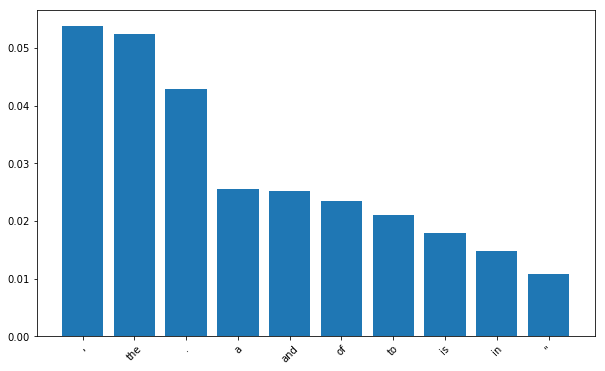

In [6]:
def plot_top_k(alpha, label='pos', k=10):
    positive_words = [w for (w,y) in alpha.keys() if y == label]
    sorted_positive_words = sorted(positive_words, key=lambda w:-alpha[w,label])[:k]
    util.plot_bar_graph([alpha[w,label] for w in sorted_positive_words],sorted_positive_words,rotation=45)
plot_top_k(alpha)

This is actually fairly uninformative. What we see are words that appear with high probability in positive documents. Clearly *any* document will contain these words with high probability, and so they don't serve well to discriminate between document classes. It makes sense to remove such words apriori, using a so-called *stop-word* list.  

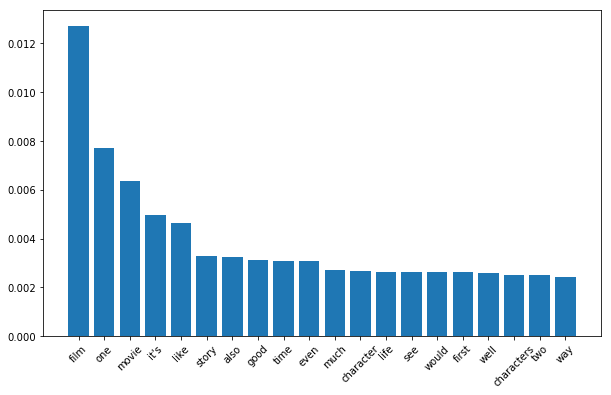

In [7]:
import string

stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the'] + list(string.punctuation))

def filter_dataset(data):
    """
    Removes stop words from a dataset of (x,y) pairs.
    """
    return [([w for w in x if w not in stop_words],y) for x,y in data]

train_filtered = filter_dataset(train)
dev_filtered = filter_dataset(dev)
test_filtered = filter_dataset(test)

theta_filtered = (alpha, beta) = train_nb(train_filtered,pseudo_count=0.01)
plot_top_k(alpha,'pos',k=20)

At this point we see some words that may indicate positive movie reviews ("good", "like"), but also words that are generally likely to appear in movie reviews, regardless of the review's sentiment. Let us also look at the conditional probabilities for negative sentiment:

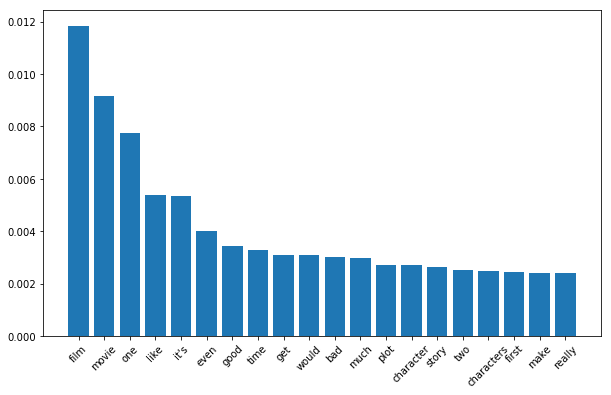

In [8]:
plot_top_k(alpha,'neg', 20)

Interestingly, the negative reviews look fairly similar when considering the head of the distribution, and even mention "good" just as often as the positive reviews. However, note some subtle differences: in negative reviews the word "movie" is used more often than in positive reviews; for the word "film" this effect is reversed. 

Notably "bad" appears with high probability only in the negative reviews. Let's look at some occurences of "good" in negative reviews to check whether this actually makes sense.  

In [9]:
docs_with_good = [x for x,y in train if 'good' in x and y=='neg']
good_index = docs_with_good[1].index("good")
docs_with_good[1][good_index-5:good_index+5]

['is',
 'neither',
 'bad',
 'enough',
 'nor',
 'good',
 'enough',
 'to',
 'be',
 'enjoyable']

Generally, looking at the most likely words in each class is not that helpful in order to understand the NB classification model, as discriminative features or words may be rare when compared to general words in the domain (such as "film", "movie", "story" in movie reviews). We can instead look at probability *ratios* or *differences*: which words have much higher probability in one class than the other.   

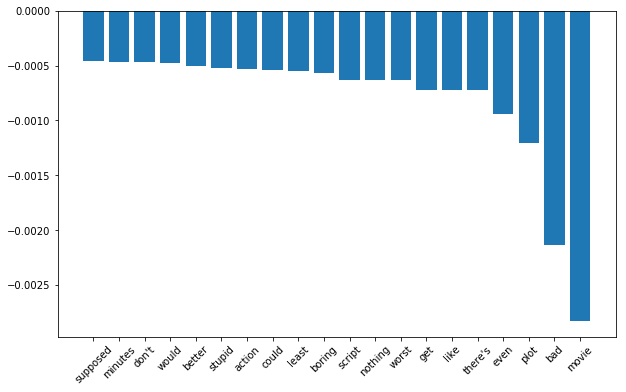

In [10]:
def diff(alpha, w):
    return alpha[w,'pos'] - alpha[w,'neg'] 

def plot_discriminative_features(alpha, threshold = 0.0001, reverse=False):
    frequent_words = {w for ((w,y),p) in alpha.items() if p > 0.0001}
    sorted_by_ratio = sorted(frequent_words, key=lambda w: diff(alpha, w),reverse=reverse)[-20:]
    util.plot_bar_graph([diff(alpha,w) for w in sorted_by_ratio],sorted_by_ratio,rotation=45)

plot_discriminative_features(alpha,reverse=True)

Many of these words seem to match our intuition for negative reviews.

###  Naive Bayes Prediction
Given a trained NB model, how do we predict the class of a given text? As we have done in [MT](word_mt.ipynb) and [parsing](word_mt.ipynb), we search for the $y\in\Ys$ with maximum *a posteriori* probability:

$$
\argmax_{y\in\Ys} \prob_\params(y|\x) =  \argmax_{y\in\Ys} \frac{\prob(\x|y) \prob(y) }{ \prob(\x) } = \argmax_{y\in\Ys} \prob(\x|y) \prob(y) 
$$
where the last equation follows from the fact that $\prob(\x)$ is constant for each $y$ we plug in.

In python we implement this decoder in two steps. First we introduce a function that returns $\prob(\x|y) \prob(y)$, then we search for the label with the highest return value of this function. 

Notice how we only take words into account that appear in the parameters of $\balpha$. This trick deals with the problem of words that have not been seen at all in the training set. The underlying assumption is that these words have the same probability under both models, and hence can be ignored when comparing the probabilities of the whole document. 

In [11]:
from math import log, exp
def log_prob_nb(theta, x, y):
    """
    Calculates the log probability log(p_theta(x|y)).
    """
    alpha, beta = theta
    result = util.safe_log(beta[y])
    for w in x:
        if (w,y) in alpha:
            result += util.safe_log(alpha[w,y])
    return result

def predict_nb(theta, x):
    """
    Finds y^*=argmax_y p_theta(y|x)
    """
    if log_prob_nb(theta, x, 'pos') > log_prob_nb(theta, x, 'neg'):
        return 'pos'
    else:
        return 'neg'

i = 5
predict_nb(theta_filtered,train_filtered[i][0]), train_filtered[i][1]

('pos', 'pos')

## Evaluation
We can evaluate a classification model by measuring its **accuracy**, the ratio of the number of correct predictions  and the number of instances. Let $\y^*$ be a predicted sequence of labels, and $\y$ the true labels. Then

$$
\mathrm{Acc}(y_1,\ldots,y_n, y^*_1,\ldots,y^*_n, ) = \frac{\sum_i \indi [ y_i = y^*_i]}{n}
$$

In [12]:
def accuracy(data, guess):
    correct = 0
    for (x,y),y_guess in zip(data,guess):
        if y_guess == y:
            correct += 1
    return correct / len(data)

def batch_predict_nb(theta, data):
    return [predict_nb(theta, x) for x,_ in data]

def accuracy_nb(theta,data):
    return accuracy(data, batch_predict_nb(theta,data))

theta_filtered = (alpha, beta) = train_nb(train_filtered,pseudo_count=2.0)
accuracy_nb(theta_filtered, train_filtered), accuracy_nb(theta_filtered, dev_filtered)  

(0.979375, 0.815)

Accuracy is particularly suitable when the dataset is balanced. For unbalanced datasets other metrics are often preferred. For example, when a "none of the above" label exists that dominates the dataset, it is useful to measure precision, recall and the so called $\mathrm{F}_1$ score, the geometric mean of precision and recall.   

Notice that we can sometimes do a bit better by counting each word in the document only once. Here, however, this does not make a difference.

In [13]:
def binarize_dataset(data):
    return [(set(x),y) for x,y in data]

train_binary = binarize_dataset(train_filtered)
dev_binary = binarize_dataset(dev_filtered)
test_binary = binarize_dataset(test_filtered)

theta_binary = train_nb(train_binary, 2.0)
accuracy_nb(theta_binary, dev_binary) 

0.83

## Broken Assumptions

The Naive Bayes assumption can make sense, as some words a strongly correlated with the class labels, but not necessarily with each other once we know the class label. For example, if once you a review is positive, the probability of seeing "great" will be larger, and so will be the probability of seeing "awesome", but seeing one of these does not necessarily increase the probability of the other any further. 

$\prob(\text{... great ... awesome}\bar +) \approx \ldots \prob(\text{great}\bar +) \ldots \prob(\text{awesome}\bar +) \ldots$

Importantly, this does not mean that the event of seeing one word is independent of the event of seeing the other. They are only independent once we know the class.  

However, there are many cases where the NB assumption is violated. Let us consider the following dataset to illustrate this:

---------------------------
|$\x$                 |$y$| 
|---------------------|---|
|... Pulp Fiction ... | + |
|... Pulp Fiction ... | + |
|... Pulp Fiction ... | + |
|... Fiction ...      | - |
|... Fiction ...      | - |
|... Pulp Fiction ... | - |

Let us assume we train a NB model on this data. What will be the probability $p(\text{Fiction}\bar \text{Pulp},+)$ according to the Naive Bayes Model? It will be $p(\text{Fiction}\bar+)$, the probability of seeing "Fiction" in positive documents, regardless of its preceeding word, or any other word seen in the document.  

Now, what is $p(\text{Fiction}\bar \text{Pulp},+)$ according to the data? This probability is 1: whenever we see "Pulp" in positive reviews we will always see "Fiction". 

NB will therefore **underestimate** $p(\text{Pulp Fiction}\bar +)$ which should be $p(\text{Pulp}\bar +)$ but is times $p(\text{Fiction}\bar+)$ smaller. This means that we may misclassify instances that mention "Pulp Fiction", or generally any instances that contain highly correlated words. Notice that $p(\text{Pulp Fiction}\bar -)$ would also be underestimated, but in this case, to a lesser extent. 

### Bigram Representation
We can address the above problem partially by using a *bigram* representation of the document. Instead of applying NB to a sequence of words and ignoring context, we can apply it to a sequence of document bigrams. So the document (a,good,job) would become ((a,good),(good,job)). Let us do this for our running example by transforming the datasets accordingly.

In [14]:
def bigram_dataset(data):
    return [([tuple(x[i:i+2]) for i in range(0,len(x)-1)],y) for x,y in data]

train_bigram = bigram_dataset(train_filtered)
dev_bigram = bigram_dataset(dev_filtered)
test_bigram = bigram_dataset(test_filtered)

theta_bigram = (alpha_bigram, beta_bigram) = train_nb(train_bigram, 0.1)
accuracy_nb(theta_bigram, dev_bigram) 

0.775

The bigram representation improves the results substantially. We can look at the most discriminative features again to understand what aspect of the data the model picked up upon.

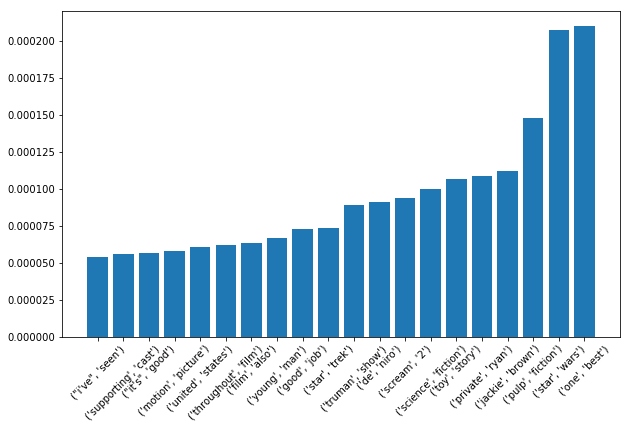

In [15]:
plot_discriminative_features(alpha_bigram, reverse=False)

Interestingly the model has learned to pick up on a completely different type of phenomenon: the presence of entities such as movies and actors. For example, the presence of "pulp fiction" seems to correlate with positive reviews. Often reviewers praise a good movie by its resemblance to "pulp fiction". We can see this by printing out a few such reviews.

In [16]:
docs_with_good = [x for x,y in train if 'pulp' in x and 'fiction' in x and y=='pos']
for doc_index in range(0,14):
    good_index = docs_with_good[doc_index].index("pulp")
    print(" ".join(docs_with_good[doc_index][good_index-10:good_index+10]))

in essence , this is the science fiction equivolence of pulp fiction . the easiest way to write a review
than anything actually shown--like most of the violence in " pulp fiction " . " se7en " is gory ,
, the film is paced at half the speed of pulp fiction , which avary co-wrote with quentin tarantino .
this statement , but you need look no further than pulp fiction for an example ) . and , while

since this is a gritty crime comedy , flashbacks of pulp fiction should arise ) . at first , i
, stock & two smoking barrels ( 8/10 ) - pulp fiction ( 8/10 ) - reservoir dogs ( 9/10
incredibly fun to watch . it starts off as a pulp fiction-type crime story , with criminal brothers george clooney
can be even more graphic ( e . g . pulp fiction ) . pulp fiction did it in a
you couldn't find in any of the two dozen " pulp fiction " wannabes ; fortunately , the reappearance of
but if most of those movies have their roots in pulp fiction , exploring a modern myth of the doomed
the three years sinc

## Discriminative Text Classification

The bigram representation can lead to improvements, but at the same time suffers from more sparsity issues. Is it possible to effectively capture features such as "pulp fiction" without moving to a sparser bigram representation?

Recall that the problem is the fact that positive documents with "Pulp Fiction" may receive a too low probability under the positive class, and if this probability is lower than the probability of the negative class, the instance will be misclassified. Formally, we may have

$$
\prob(\text{...Pulp Fiction...}, +) < \prob(\text{...Pulp Fiction...}, -)
$$

for a positive instance. We can also phrase this in terms of the *a posteriori* probability of "+":

$$
\prob(+ \bar \text{...Pulp Fiction...}) = \frac{\prob(+ , \text{...Pulp Fiction...})}{\prob(+, \text{...Pulp Fiction...}) + \prob(- , \text{...Pulp Fiction...})} < \frac{1}{2}
$$

Looking at the data table again, it is clear that we can't increase $\prob(\text{Fiction}\bar +)$ as this would also increase the probability of "+" in three negative instances. However, we can also increase $\prob(+ \bar \text{...Pulp Fiction...})$ by decreasing $\prob(- , \text{...Pulp Fiction...})$, the probability of the negative class in positive instances mentioning "Pulp Fiction". Now this in turn can be achieved by decreasing $\prob(\text{Pulp}\bar -)$, and this will only move the probability of one negative instance (the 6th) in the wrong direction. 

How can we operationalise this idea of penalising features in order to increase the conditional probability of the correct class? There is an intuitive alternative objective to the log-likelihood that achieves this: the *conditional* (log-)likelhood (CL) of the data:

$$
\mathit{CL}(\params) = \sum_{(\x,y) \in \train} \log(\prob_\params(y \bar \x)) = \sum_{(\x,y) \in \train} \log\left(\frac{\prob_\params(y,\x)}{\sum_y \prob_\params(y,\x)}\right)
$$

The CL objective can be increased both by assigning more probability to the training instance (as before in the joint objective), but also by assigning less probability to the other classes in sum of the denominator. It could hence down-weigh $\prob(\text{Pulp} \bar -)$ whenever "Pulp" is seen in a positive review.  

The CL objective also makes sense from another point of view: you should always train to optimise the actual prediction rule. In the case of classification we are looking for the class $y$ with highest *a posteriori* probability $\prob(y \bar \x)$, and this is precisely the quantity the CL is encouraging to be large for each training instance.   

## Log-Linear Models
Before we discuss how to train classifiers using the CL objective we will introduce a *log-linear* representation for probabilistic models. This representation simplifies the math and enables a richer set of models later on. 

In log-linear form the joint NB distribution $p^{\text{NB}}_{\params}(\x,y)$ can be written as:  

\begin{equation}
  p^{\text{NB}}_{\weights}(\x,y)= \exp \left( \sum_{i \in \mathcal{I}} f_i(x) w_{y,i} \right) = \exp \langle \mathbf{f}(\x), \mathbf{w}_y \rangle = \exp s_\weights(\x,y)
\end{equation}

where $s_\weights(\x,y) = \langle \mathbf{f}(\x), \mathbf{w}_y \rangle$ is the linear *score* of $(\x,y)$.

Likewise, the conditional probability has the form:

\begin{equation}
  p^{\text{NB}}_{\params}(y|\x)= \frac{1}{Z_\x} \exp \langle \mathbf{f}(\x), \mathbf{w}_y \rangle = \frac{1}{Z_\x} \exp s_\weights(\x,y)
\end{equation}

where $Z_\x=\sum_{y\in\Ys} \exp s_\weights(\x,y)$ is the *partition function*.

Here the $f_i$ are so called *feature functions*. The index set $\mathcal{I}$ contains an index for the *bias* feature $f_0$ and one for each word $x$ in the vocabulary. The corresponding feature functions are defined as follows:

\begin{split}
  f_{0}(\x) & = 1  \\\\
  f_{x'}(\x) & = \sum_i^{\text{length}(\x)} \delta(x',x_i) 
\end{split}

In words, the first feature function $f_0$ always returns 1 and hence serves as a *bias* feature. The second feature function returns the number of times the word $x'$ appears in $\x$.

If one now sets the weights according to

\begin{split}
  w_{y'} & = \log \beta_{y'}\\\\
  w_{x',y'} & = \log \alpha_{x',y'}
\end{split}

it is easy to show that $\ref{eq-loglinear}$ is equivalent to the original NB formulation in equation $\ref{eq:NB}$. 

It is worthwhile to view the conditional log-likelihood in log-linear form:

$$
\mathit{CL}(\weights) = \sum_{(\x,y) \in \train} \log(\frac{1}{Z_\x} \exp s_\weights(\x,y) = \sum_{(\x,y) \in \train} s_\weights(\x,y) - \log Z_\x.
$$

This form should remind you of the log-loss defined in the [exercise solutions](http://localhost:8888/notebooks/exercises/structured_prediction_solutions.ipynb). It encourages high scores $\langle \mathbf{f}(\x), \mathbf{w}_y \rangle$ of the gold solution, and low scores of the rest $\log Z_\x = \log \sum_{y\in\Ys} \exp s_\weights(\x,y)$. 

Through simple changes to the above objective one can arrive at other standard loss/reward functions. For example, instead of subtracting the exponentiated scores of all solutions, one can only subtract the score of the current predicted solution:

$$
\mathit{PERCEPTRON}(\weights) = \sum_{(\x,y) \in \train} s_\weights(\x,y) - s_\weights(\x,y^*(\x))
$$

where $y^*(\x)=\argmax_{y\in\Ys} s_\weights(\x,y)$ as usual. When optimising this reward via gradient descent one arrives at the perceptron algorithm, and its natural extension to [structured prediction](todo:collins paper). Note that for a given instance this reward is maximal (zero) only if the score of the gold solution $y$ is at least as high as the score of any other solution. It hence directly encourages the gold $y$ to "win".   



## Regularisation
Estimating a log-linear model using the conditional log-likelihood can sometimes lead to *overfitting*. For example, for example, the reviews of movies may often contain the name of the movie to reviewed. This name is a false *killer feature* in the sense that it likely only appears in one training instance, and its weight can be set in way that we get perfect accuracy on this instance (if the instance is positive, we set this weight to be very high for $\mathrm{pos}$ and low for $\mathrm{neg}$, and vice versa for negative instances). This gives high training accuracy, but it will not generalise at all. 

To address this issue it is useful to *regularise* the model by penalising large weights. This is achieved by adding a regularisation penalty to the training objective. Most common are two types of terms, $||\weights||_2$ and $||\weights||_1$, the L2 and L1 norm of the weight vector. The training objective then becomes

$$
\mathit{RCL}(\weights) = \sum_{(\x,y) \in \train} \log(\prob_\weights(y|\x)) - \frac{1}{C} ||\weights||_2
$$

in the case of the L2 regulariser. Here the parameter $C$ controls the inverse strength of regularisation.

Both L1 and L2 have their strength and weaknesses. L1 regularisation can lead to sparse vectors with zero weights, and this can improve the memory footprint of your model. L2 seems can lead to [better results](http://www.csie.ntu.edu.tw/~cjlin/liblinear/FAQ.html#l1_regularized_classification). Notice that learning with regularisation can also be understood as maximum-a-posteriori inference of the parameters under [specific priors](http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf). For example, L2 regularisation assumes a Gaussian prior.  

## Optimising the Conditional Loglikelihood
In contrast to the [joint loglikelihood objective](mle.ipynb) the conditional loglikelihood has no closed form solution. Instead the solution has to be found using iterative methods. Most commonly this is achieved through gradient algorithms such as L-BFGS or Stochastic Gradient Descent. 

In practice you will optimise the CL (and other training objectives) in one of the following ways:
* You have to implement both optimisation code and gradient calculation.
* You have an off-the-shelf gradient descent library that calls your client code to ask for the gradient of the objective at the current parameters. (Example: [factorie](http://factorie.cs.umass.edu/))
* You have a back-propagation framework (such as Tensorflow) that requires you to declare the training objective *declaratively* and then provides gradients automatically
* You have a library (such as scikit-learn) for a specific model class that provides tailor-made and built-in gradients and optimisation methods.

Here we will consider the third case and work with a classifier toolkit that optimises the CL. However, in other chapters we will optimise the CL (and other variants of training objectives) using some of the other approaches. 

To prepare for these cases, and to give a better intuition for CL objective, it is useful to understand the CL gradient:

\begin{split}
  \nabla_{\weights_{y'}} CL(\params) =  \sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y') - p_\params(y'|\x) \mathbf{f}(\x) = \sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y') - \sum_{(\x,y) \in \train} p_\params(y'|\x) \mathbf{f}(\x).
\end{split}

Because the conditional log-likelhood is a strictly concave function, we have found a solution $\weights*$ when this gradient is zero. When will it be zero? When the empirical expectations $\sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y')$ for class $y'$ match the model expectations $\sum_{(\x,y) \in \train} p_\params(y'|\x) \mathbf{f}(\x)$. This gives rise to a *dual* view on maximising the conditional likelihood: it finds a distribution with the same moments as the empirical distribution. There are actually several such distributions, and maximimising the conditional likelihood corresponds to finding the distribution that matches moments, and has [maximum entropy](todo).



## Logistic Regression Toolkits
A log-linear model trained by maximising the CL in fact corresponds to a *logistic regression* with maximum-likelihood estimation, as well as the so called *maximum entropy* approach. This means that we can use tools branded as logistic regression or maximum entropy software to train CL optimised models.  

Here we use the [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation of [scikit-learn](http://scikit-learn.org/stable/index.html). As it is common with such libraries, we have to first convert our data into a vector form. That is, every $\x \in \Xs$ should be converted to a (sparse) feature vector $\mathbf{f}(\x)$, and every $y\in\Ys$ to a real number. `scikit-learn` comes with build-in support for this type of conversion, for example in the form of the `DictVectorizer` for inputs $\x$ and the `LabelEncoder` for labels $y$.

Let us first convert the input data into vectors. We do this by first providing a dictionary representation of the feature vector in `to_dict`, and then use the scikit-learn `DictVectorizer` to turn these dictionaries into vectors.

In [17]:
from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()

def to_dict(x):
    result = defaultdict(float)
    for w in x:
        result[w] += 1.0
    return result

train_X = vectorizer.fit_transform([to_dict(x) for x,_ in train_filtered])
dev_X = vectorizer.transform([to_dict(x) for x,_ in dev_filtered])

Next we convert the labels using the `LabelEncoder`.

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_Y = label_encoder.fit_transform([y for _,y in train_filtered])
dev_Y = label_encoder.transform([y for _,y in dev_filtered])

Finally, we can train the logistic regression model using a regularisation parameter $C=0.25$.

In [19]:
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression(C=0.25, solver='liblinear')
lr.fit(train_X, train_Y)

LogisticRegression(C=0.25, solver='liblinear')

Let us have a look at the weights the model learned. Note that the scikit-learn package only learns one set of weights, not one for each class. It is easy to see that this is equivalent, as you can always convert a model with two sets of weights to one with only one weight vector by subtracting the weights of the negative class from the weights of the positive class.

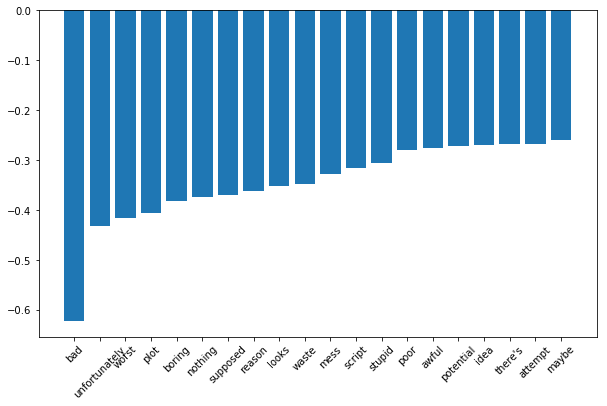

In [20]:
# Exercise: why is there only one coefficient vector
# lr.predict_proba(train_X[10])
weights = vectorizer.inverse_transform(lr.coef_)[0]
sorted_weights = sorted(weights.items(), key=lambda t: t[1])
util.plot_bar_graph([w for _,w in sorted_weights[:20]],
                    [f for f,_ in sorted_weights[:20]],rotation=45)

Interestingly, the features we see now are much more obvious **discriminative** features for the negative class. Intuitively, the conditional log-likelihood leads to such discriminative weights because it down-weighs a feature $f_i$ for a class $y$ if $f_i$ is active in an instance $\x$, but the label of the instance is **not** $y$. Frequent but non-discriminative words hence get constantly pushed down.   

You can change the order of weights to see the features indicative of the positive class. 

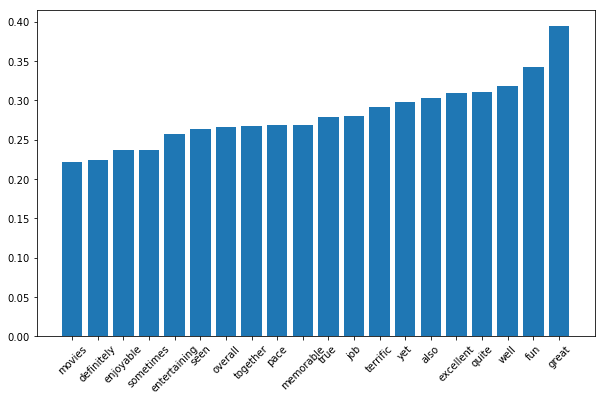

In [21]:
util.plot_bar_graph([w for _,w in sorted_weights[-20:]],
                    [f for f,_ in sorted_weights[-20:]],rotation=45)

In terms of accuracy, the discriminative training regime leads to substantial improvements: 

In [22]:
lr_guess = label_encoder.inverse_transform(lr.predict(dev_X))
accuracy(dev_filtered, lr_guess)

0.785

This is remarkable, as the underlying model is the unigram model we had at 0.80 accuracy when trained by maximising the joint likelihood. The same model, when trained discriminatively, leads to 3 points improvements without changing the representation.

## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://www.aclweb.org/anthology/P12-2018), Sida Wang and Christopher D. Manning, ACL 2012 
* [Thumbs up? Sentiment Classification using Machine Learning
Techniques](http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf), Bo Pang, Lillian Lee and Shivakumar Vaithyanathan, EMNLP 2002
* Jurafsky & Martin, [Speech and Language Processing (Third Edition)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf): Chapter 4, Naive Bayes and Sentiment Classification + Chapter 5, Logistic Regression
* Statistical NLP Book, lecture notes on [Maximum Likelihood Estimation](https://github.com/copenlu/stat-nlp-book/blob/master/chapters/mle.ipynb)